In [68]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
from math import ceil, log2
from decimal import Decimal, getcontext
getcontext().prec = 100

In [69]:
def convert_to_grayscale(matrix):
  shape = matrix.shape
  grayscale = np.zeros((shape[0],shape[1]),dtype="int")
  for i in range(shape[0]):
    for j in range(shape[1]):
      grayscale[i][j] = round(0.299*matrix[i][j][0] + 0.587*matrix[i][j][1] + 0.114*matrix[i][j][2])
  return grayscale

In [70]:
def load_image(path):
  matrix=cv2.imread(path)
  grayscale = convert_to_grayscale(matrix)
  fig, axs = plt.subplots(1, 2, figsize=(10, 5))

  axs[0].imshow(matrix)
  axs[0].set_title("Original Image")
  axs[0].axis('off')
  axs[1].imshow(grayscale, cmap='gray')
  axs[1].set_title("Grayscale Image")
  axs[1].axis('off')
  plt.show()

  return grayscale

In [71]:
def probabilities(grayscale):
  total_pixels = grayscale.shape[0] * grayscale.shape[1]
  unique_values, counts = np.unique(grayscale, return_counts=True)
  probs = counts / total_pixels
  probs_dict = dict(zip(unique_values, probs))
  sorted_values = sorted(probs_dict.keys())
  sorted_probs = [probs_dict[key] for key in sorted_values]
  return sorted_values, sorted_probs

In [72]:
def create_intervals(values, probs):
    cumulative_prob = Decimal(0.0)
    intervals = {}
    for i in range(len(values)):
        lower_bound = cumulative_prob
        upper_bound = cumulative_prob + Decimal(probs[i])
        intervals[values[i]] = (lower_bound, upper_bound)
        cumulative_prob = upper_bound
    return intervals

In [73]:
def arithmetic_encode(sequence, intervals):
    low = Decimal(0.0)
    high = Decimal(1.0)
    for value in sequence:
        range_ = high - low
        high = low + range_ * intervals[value][1]
        low = low + range_ * intervals[value][0]
    return low + (high - low) / 2

In [74]:
def arithmetic_decode(encoded_value, intervals, length):
    sequence = []
    for _ in range(length):
        for value, (low, high) in intervals.items():
            if low <= encoded_value < high:
                sequence.append(value)
                encoded_value = (encoded_value - low) / (high - low)
                break
    return sequence

In [75]:
def calculate_compression(original_size, encoded_value):
    encoded_value_bits = ceil(-log2(encoded_value))
    compression_ratio = original_size / encoded_value_bits

    return encoded_value_bits, compression_ratio

In [86]:
def calculate_error_percentage(original, decoded):
    error_matrix = np.abs(decoded.astype(int) - original.astype(int))
    max_pixel_value = 255
    total_pixels = original.size
    error_sum = np.sum(error_matrix)
    average_error = error_sum / total_pixels
    error_percentage = (average_error / max_pixel_value) * 100

    return error_percentage

In [87]:
def arithmetic_compression(input_path, output_path):
  grayscale = load_image(input_path)
  values, probs = probabilities(grayscale)
  intervals = create_intervals(values, probs)
  flatten_sequence = grayscale.flatten()

  encoded_value = arithmetic_encode(flatten_sequence, intervals)
  decoded_sequence = arithmetic_decode(encoded_value, intervals, len(flatten_sequence))

  decoded_sequence = np.clip(np.array(decoded_sequence).reshape(grayscale.shape), 0, 255)
  plt.imshow(decoded_sequence, cmap='gray')
  plt.title("Decoded Image")
  plt.axis('off')
  plt.show()
  original_size_bits = flatten_sequence.size * 8
  encoded_value_bits, compression_ratio = calculate_compression(original_size_bits, encoded_value)
  error_percentage = calculate_error_percentage(grayscale, decoded_sequence)

  print(f"Original Size (in bits): {original_size_bits}")
  print(f"Encoded Value Size (in bits): {encoded_value_bits}")
  print(f"Compression Ratio: {compression_ratio:.2f}")
  print(f"Error Percentage: {error_percentage:.2f}%")

  cv2.imwrite(output_path, decoded_sequence)



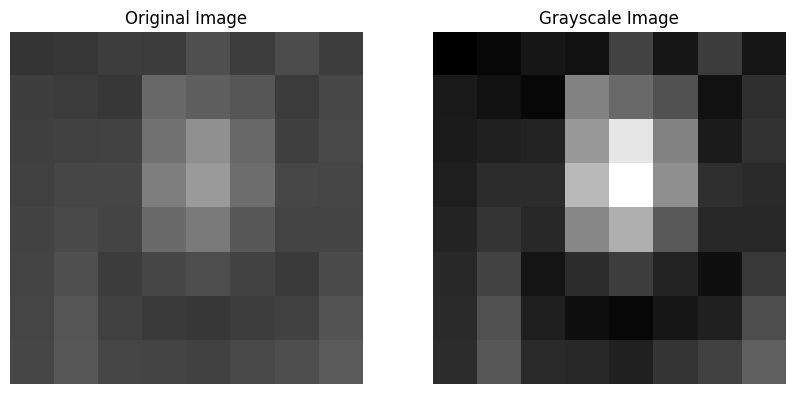

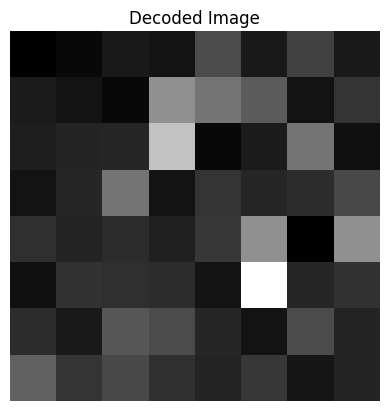

Original Size (in bits): 512
Encoded Value Size (in bits): 12
Compression Ratio: 42.67
Error Percentage: 5.69%


In [88]:
arithmetic_compression('/content/image1.png','/content/decoded_image1.png')